In [1]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [2]:
#data path
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrAandNearby'
dpathalt='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_C'

#file name
fname='F0590_FO_IMA_07018928_FORF253_CAL_0024-0055_Field_Q.fits'

#Name of field
field='FieldQ'

#wavelength of data
wavelength=25.2

In [3]:
#change directory to data location
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

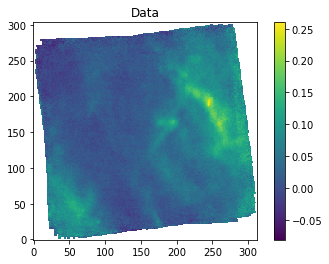

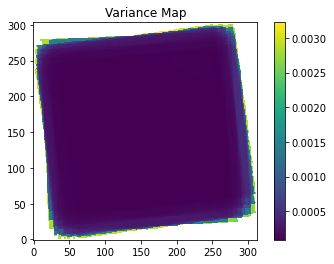

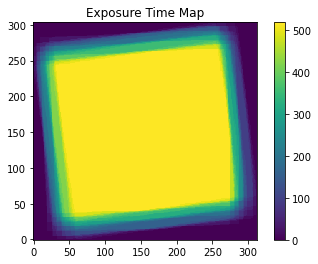

In [4]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

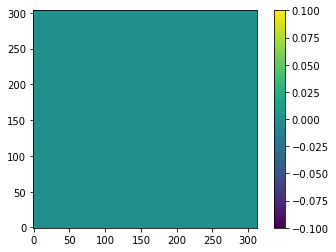

In [5]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.5,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
#mask2[0:100,0:250]=1

mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [6]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(20, 20), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

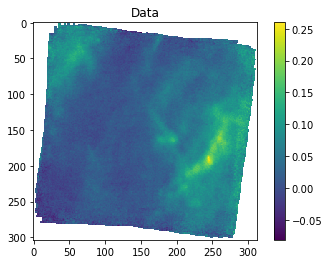

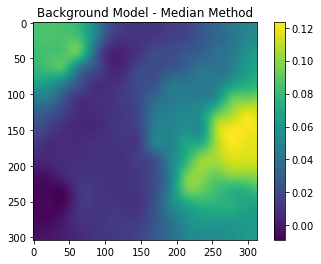

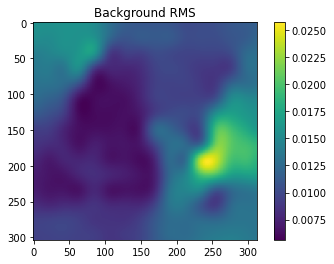

In [7]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [8]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

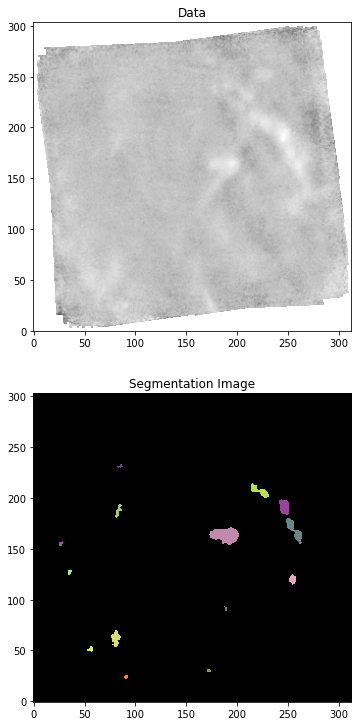

In [9]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [10]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,90.61492687771323,24.640309140574104,"266.50145715050087,-28.83668167792607",0.054982818704254054,0.03992679799614372,0.5190483739498684,13.0,1.0369085165802339,0.8972087141432724,41.23033638932585,1.0656891713553969,-0.30948524891270907,1.1066498062031858,0.5013013237552372,0.13472722058229114,1.155704910390174,2.283181559237499,5.476439738980888,nan,3.4708397918275073,0.7456311324712208,nan
2,172.30452237095992,30.37502872875032,"266.481563179429,-28.835459284475107",0.0075978470681748785,0.017232632797467343,0.1206284295822714,7.0,1.0474425486371917,0.46641823611025446,-7.952432286843481,0.9820037002575105,1.0099133616691007,4.526189999808118,0.8953851982215415,0.5547075715827061,2.2457152562739666,1.9092071937193056,2.337827490418553,nan,3.6200039757519487,0.2889221440945532,nan
3,56.0670305762564,51.40265985425275,"266.5098692728245,-28.83097107138005",0.07924565683855914,0.08061283063790649,1.7734822740339427,22.0,1.6240026060909338,1.2491972013951917,36.28347850119118,0.4707977953366287,-0.2496407176055069,0.5491885917070394,0.6389974350487139,0.23079113499572512,1.3000370191969153,3.4115963290271316,16.6460505467627,nan,3.7802568754186776,1.1059485191918226,nan
4,80.5791964167023,61.52240396616344,"266.50389971121945,-28.828813173629516",0.030473940282995823,0.0297568828231408,2.7078763369058128,91.0,4.143450083654919,1.820509220703709,88.1692621476341,0.30147854375261374,-0.015548937711077203,0.05849579467706794,0.8983060017596021,0.5606296241180138,2.2759841238559004,7.535871623595656,27.511719109528144,nan,3.455719582499839,3.566875583347226,nan
5,188.26426189310567,91.30873893213231,"266.4776773868715,-28.822459951666836",0.010518613827376745,0.042506772954476336,0.29754741068133433,7.0,1.1417347474994641,0.5386233681333308,-62.0686129491324,2.8589334958793273,2.218039914321426,1.3551049645392692,0.881727663655696,0.528241240521951,2.1197274664415215,2.102046812625134,3.546910207935427,nan,3.814113265473706,0.20686810140362658,nan
6,254.23566452464098,120.17393358744883,"266.4616148118917,-28.816300272707046",0.011137746918512648,0.07684713314863789,3.9960509237291704,52.0,2.3864666045349794,1.7565938453246712,-89.14095794656797,0.32405039427524407,0.004452227643094517,0.17561913303075694,0.6769111796078332,0.2639352916204094,1.3585762075204635,4.934133281744459,19.260191923248584,nan,3.523714670266702,2.3946742418763747,nan
7,35.18188012673511,127.33805200577771,"266.51495046961196,-28.814770481390198",0.00680084721022098,0.019465729441130782,0.3114516710580925,16.0,1.3845105428693487,0.9019437341742029,65.52556863122521,1.1078098223811643,-0.5335942661016186,0.6431266385647438,0.7586888771766244,0.34854686458005824,1.5350298365750852,2.751399363323057,5.6015911225872745,nan,3.69562647579778,0.5486552702544589,nan
8,26.904692354466,154.84488708697282,"266.51696397998234,-28.80890189173461",0.012647644186789087,0.011635227329979951,0.12798750062977945,11.0,1.3287628111211014,0.6453834032072234,66.64260447953328,2.112495812494772,-1.3354022601851203,0.8547270981518047,0.8741241863920348,0.5142975120874269,2.0588735386095056,2.4597052640479333,3.546507219724046,nan,3.6556181068365365,0.3303218908836874,nan


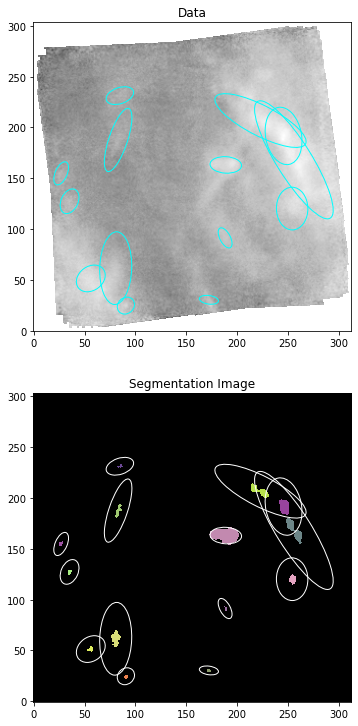

In [11]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

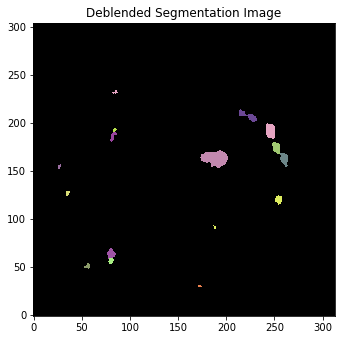

In [12]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [13]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,90.61492687771323,24.640309140574104,"266.50145715050087,-28.83668167792607",0.054982818704254054,0.03992679799614372,0.5190483739498684,13.0,1.0369085165802339,0.8972087141432724,41.23033638932585,1.0656891713553969,-0.30948524891270907,1.1066498062031858,0.5013013237552372,0.13472722058229114,1.155704910390174,2.283181559237499,5.476439738980888,nan,3.4708397918275073,0.7456311324712208,nan
2,172.30452237095992,30.37502872875032,"266.481563179429,-28.835459284475107",0.0075978470681748785,0.017232632797467343,0.1206284295822714,7.0,1.0474425486371917,0.46641823611025446,-7.952432286843481,0.9820037002575105,1.0099133616691007,4.526189999808118,0.8953851982215415,0.5547075715827061,2.2457152562739666,1.9092071937193056,2.337827490418553,nan,3.6200039757519487,0.2889221440945532,nan
3,56.0670305762564,51.40265985425275,"266.5098692728245,-28.83097107138005",0.07924565683855914,0.08061283063790649,1.7734822740339427,22.0,1.6240026060909338,1.2491972013951917,36.28347850119118,0.4707977953366287,-0.2496407176055069,0.5491885917070394,0.6389974350487139,0.23079113499572512,1.3000370191969153,3.4115963290271316,16.6460505467627,nan,3.7802568754186776,1.1059485191918226,nan
4,188.26426189310567,91.30873893213231,"266.4776773868715,-28.822459951666836",0.010518613827376745,0.042506772954476336,0.29754741068133433,7.0,1.1417347474994641,0.5386233681333308,-62.0686129491324,2.8589334958793273,2.218039914321426,1.3551049645392692,0.881727663655696,0.528241240521951,2.1197274664415215,2.102046812625134,3.546910207935427,nan,3.814113265473706,0.20686810140362658,nan
5,254.23566452464098,120.17393358744883,"266.4616148118917,-28.816300272707046",0.011137746918512648,0.07684713314863789,3.9960509237291704,52.0,2.3864666045349794,1.7565938453246712,-89.14095794656797,0.32405039427524407,0.004452227643094517,0.17561913303075694,0.6769111796078332,0.2639352916204094,1.3585762075204635,4.934133281744459,19.260191923248584,nan,3.523714670266702,2.3946742418763747,nan
6,35.18188012673511,127.33805200577771,"266.51495046961196,-28.814770481390198",0.00680084721022098,0.019465729441130782,0.3114516710580925,16.0,1.3845105428693487,0.9019437341742029,65.52556863122521,1.1078098223811643,-0.5335942661016186,0.6431266385647438,0.7586888771766244,0.34854686458005824,1.5350298365750852,2.751399363323057,5.6015911225872745,nan,3.69562647579778,0.5486552702544589,nan
7,26.904692354466,154.84488708697282,"266.51696397998234,-28.80890189173461",0.012647644186789087,0.011635227329979951,0.12798750062977945,11.0,1.3287628111211014,0.6453834032072234,66.64260447953328,2.112495812494772,-1.3354022601851203,0.8547270981518047,0.8741241863920348,0.5142975120874269,2.0588735386095056,2.4597052640479333,3.546507219724046,nan,3.6556181068365365,0.3303218908836874,nan
8,245.80982007795427,191.6663174019684,"266.46366943546377,-28.80104889726128",0.05166458492909211,0.1040282834646137,13.107563716541325,126.0,3.862286218650973,2.387635132076842,-79.21895638163903,0.1716217955409828,0.039829720248074234,0.07082859743314518,0.7860269907937297,0.3818078213502262,1.6176199481917626,7.5607797570528605,45.24897551274747,nan,2.9575579434087613,12.600763412941898,nan


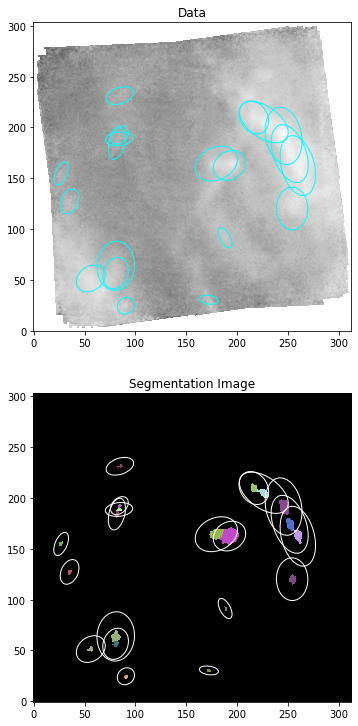

In [14]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [15]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [16]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [17]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,90.61492687771323,24.640309140574104,"266.50145715050087,-28.83668167792607",0.054982818704254054,0.03992679799614372,0.5190483739498684,13.0,1.0369085165802339,0.8972087141432724,41.23033638932585,1.0656891713553969,-0.30948524891270907,1.1066498062031858,0.5013013237552372,0.13472722058229114,1.155704910390174,2.283181559237499,5.476439738980888,0.21411324747333757,3.4708397918275073,0.7456311324712208,0.050657943,0.04021986030669873,0.04020189713262305,0.0021860889895159823,0.984780976527312
2,172.30452237095992,30.37502872875032,"266.481563179429,-28.835459284475107",0.0075978470681748785,0.017232632797467343,0.1206284295822714,7.0,1.0474425486371917,0.46641823611025446,-7.952432286843481,0.9820037002575105,1.0099133616691007,4.526189999808118,0.8953851982215415,0.5547075715827061,2.2457152562739666,1.9092071937193056,2.337827490418553,0.17307140662235182,3.6200039757519487,0.2889221440945532,0.04156367,0.017304420805567163,0.017298373039004555,0.0003197314693010888,0.716392034364406
3,56.0670305762564,51.40265985425275,"266.5098692728245,-28.83097107138005",0.07924565683855914,0.08061283063790649,1.7734822740339427,22.0,1.6240026060909338,1.2491972013951917,36.28347850119118,0.4707977953366287,-0.2496407176055069,0.5491885917070394,0.6389974350487139,0.23079113499572512,1.3000370191969153,3.4115963290271316,16.6460505467627,0.24433124009206086,3.7802568754186776,1.1059485191918226,0.047325667,0.0809175453144191,0.08127946527247185,0.0030088986504389083,0.8163206908038767
4,188.26426189310567,91.30873893213231,"266.4776773868715,-28.822459951666836",0.010518613827376745,0.042506772954476336,0.29754741068133433,7.0,1.1417347474994641,0.5386233681333308,-62.0686129491324,2.8589334958793273,2.218039914321426,1.3551049645392692,0.881727663655696,0.528241240521951,2.1197274664415215,2.102046812625134,3.546910207935427,0.12763734699105445,3.814113265473706,0.20686810140362658,0.025453497,0.04235458031618369,0.04238840902097722,0.0005312973444797878,0.36445959603300204
5,254.23566452464098,120.17393358744883,"266.4616148118917,-28.816300272707046",0.011137746918512648,0.07684713314863789,3.9960509237291704,52.0,2.3864666045349794,1.7565938453246712,-89.14095794656797,0.32405039427524407,0.004452227643094517,0.17561913303075694,0.6769111796078332,0.2639352916204094,1.3585762075204635,4.934133281744459,19.260191923248584,0.3121322596694274,3.523714670266702,2.3946742418763747,0.0705705,0.07643940659153205,0.07651572119383752,0.005558148546372698,1.1900131128953964
6,35.18188012673511,127.33805200577771,"266.51495046961196,-28.814770481390198",0.00680084721022098,0.019465729441130782,0.3114516710580925,16.0,1.3845105428693487,0.9019437341742029,65.52556863122521,1.1078098223811643,-0.5335942661016186,0.6431266385647438,0.7586888771766244,0.34854686458005824,1.5350298365750852,2.751399363323057,5.6015911225872745,0.21510532657636028,3.69562647579778,0.5486552702544589,0.04307602,0.019485514640795513,0.01944215259721932,0.0009427342095051372,0.9219463502163902
7,26.904692354466,154.84488708697282,"266.51696397998234,-28.80890189173461",0.012647644186789087,0.011635227329979951,0.12798750062977945,11.0,1.3287628111211014,0.6453834032072234,66.64260447953328,2.112495812494772,-1.3354022601851203,0.8547270981518047,0.8741241863920348,0.5142975120874269,2.0588735386095056,2.4597052640479333,3.546507219724046,0.2018893002412691,3.65561810683653

In [18]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [19]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,90.61492687774118,24.640309140545355,"266.50145715050087,-28.83668167792607",1.0715050286933656,0.06518019574992846,2.773741184012928,0.13160409795564676,4.892931267148674,0.19968506482687137,7.69913932839777,0.2696515631296445,11.369182399366082,0.34236493612128693
2,172.30452237088113,30.375028728776158,"266.481563179429,-28.835459284475107",0.7529047785174833,0.07246590347793382,2.268295347426226,0.14218102266138036,3.9765196179393207,0.2103565179160391,5.308807420869187,0.278168624572769,6.0902088916572925,0.35907243914321474
3,56.06703057627105,51.40265985417501,"266.5098692728245,-28.83097107138005",1.048682371652206,0.0465661316598307,3.8064634122141285,0.09318492709131895,7.634098506946932,0.14050328515118782,12.306888664503804,0.18787995782071795,16.80207016634467,0.23584657631228234
4,188.26426189308032,91.3087389321374,"266.4776773868715,-28.822459951666836",0.6173877689733165,0.04441968301285267,1.883245209540862,0.08889536225987664,3.625080812307484,0.13340664579144906,5.26245716646424,0.17794457914242978,6.855141912808456,0.2224819490505791
5,254.2356645247741,120.17393358745588,"266.4616148118917,-28.816300272707046",1.0024799089116403,0.04517461453689559,3.652133304592263,0.0903556288047,6.908232949393719,0.135534556512623,10.59003757771038,0.1806741274537571,13.806760045902696,0.22568326621156082
6,35.181880126752745,127.33805200578496,"266.51495046961196,-28.814770481390198",0.672192778805267,0.04985683768136587,2.1470105303003657,0.10203280079771722,4.057847872641357,0.15929751918329796,5.687989700514246,0.21877241946486364,6.785949746751038,0.27912542626860914
7,26.904692354375413,154.844887086991,"266.51696397998234,-28.80890189173461",0.598997941553167,0.06363488843285076,1.7580576341473877,0.12468830322004572,3.1180828788607156,0.1863543291613351,4.268657107048768,0.24894490185884594,nan,nan
8,245.8098200780223,191.66631740200623,"266.46366943546377,-28.80104889726128",2.760156855093515,0.044979822314237264,9.164614180912993,0.08995868093365762,16.48190161950619,0.13496894502585002,23.27047235218585,0.17999767340942785,29.471818562183053,0.2249576206925507


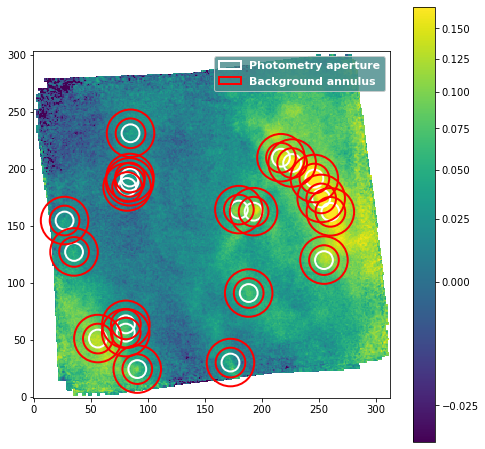

In [20]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [21]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)

In [22]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-22-d3b3f743c6c3>:12: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,90.61492687774118,24.640309140545355,"266.50145715050087,-28.83668167792607",4.892931267148674,0.19968506482687137,0.010943509560585159,0.011469730604344522,2.794539626034675,0.19968506482687137,0.010943509560585162,1.6616505541430733
2,172.30452237088113,30.375028728776158,"266.481563179429,-28.835459284475107",3.9765196179393207,0.2103565179160391,-0.002316596961699075,-0.0029867773857946527,4.4207215143554,0.2103565179160391,0.0,8.688140898050275
3,56.06703057627105,51.40265985417501,"266.5098692728245,-28.83097107138005",7.634098506946932,0.14050328515118782,0.013318597280576931,0.015089775547731851,5.080289507173748,0.14050328515118782,0.013318597280576931,2.789819984880354
4,188.26426189308032,91.3087389321374,"266.4776773868715,-28.822459951666836",3.625080812307484,0.13340664579144906,0.002531198906352349,0.003983206924302299,3.1397295090823554,0.13340664579144906,0.0025311989063523496,3.5978539019699056
5,254.2356645247741,120.17393358745588,"266.4616148118917,-28.816300272707046",6.908232949393719,0.135534556512623,0.0053528960946308685,0.007111315650355811,5.88182799597907,0.135534556512623,0.005352896094630868,4.918495124783157
6,35.181880126752745,127.33805200578496,"266.51495046961196,-28.814770481390198",4.057847872641357,0.15929751918329796,0.0033672639144078738,0.00403318005301552,3.4121831147041903,0.15929751918329796,0.003367263914407874,3.428121849073016
7,26.904692354375413,154.844887086991,"266.51696397998234,-28.80890189173461",3.1180828788607156,0.1863543291613351,0.0025345471822095025,0.003186770500158058,2.632089551791965,0.1863543291613351,0.002534547182209502,2.8934461120395327
8,245.8098200780223,191.66631740200623,"266.46366943546377,-28.80104889726128",16.48190161950619,0.13496894502585002,0.004306888860533015,0.012657802817635032,15.656066037774742,0.13496894502585002,0.004306888860533015,14.397159269007268


In [23]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [24]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,90.61492687771323,24.640309140574104,"266.50145715050087,-28.83668167792607",0.054982818704254054,0.03992679799614372,0.5190483739498684,13.0,1.0369085165802339,0.8972087141432724,41.23033638932585,1.0656891713553969,-0.30948524891270907,1.1066498062031858,0.5013013237552372,0.13472722058229114,1.155704910390174,2.283181559237499,5.476439738980888,0.21411324747333757,3.4708397918275073,0.7456311324712208,0.050657943,0.04021986030669873,0.04020189713262305,0.0021860889895159823,0.984780976527312,1.0715050286933656,0.06518019574992846,2.773741184012928,0.13160409795564676,4.892931267148674,0.19968506482687137,7.69913932839777,0.2696515631296445,11.369182399366082,0.34236493612128693,0.010943509560585159,0.011469730604344522,2.794539626034675,0.19968506482687137,0.010943509560585162,1.6616505541430733,0.8383504019029212,1.8411226768511508,3.9686652997506604,5.540316729604974,1.5155696874859967,1.6996698206459244,1.6709313954717566,1.7409689359064313,1.7409689359064313,C7FieldQ,25.2
2,172.30452237095992,30.37502872875032,"266.481563179429,-28.835459284475107",0.0075978470681748785,0.017232632797467343,0.1206284295822714,7.0,1.0474425486371917,0.46641823611025446,-7.952432286843481,0.9820037002575105,1.0099133616691007,4.526189999808118,0.8953851982215415,0.5547075715827061,2.2457152562739666,1.9092071937193056,2.337827490418553,0.17307140662235182,3.6200039757519487,0.2889221440945532,0.04156367,0.017304420805567163,0.017298373039004555,0.0003197314693010888,0.716392034364406,0.7529047785174833,0.07246590347793382,2.268295347426226,0.14218102266138036,3.9765196179393207,0.2103565179160391,5.308807420869187,0.278168624572769,6.0902088916572925,0.35907243914321474,-0.002316596961699075,-0.0029867773857946527,4.4207215143554,0.2103565179160391,0.0,8.688140898050275,0.8022605447859364,2.4657184125000393,6.098499681164441,7.324103048368626,2.9427331820395017,6.227600389489257,9.736881681122762,9.541259915062165,9.736881681122762,C7FieldQ,25.2
3,56.0670305762564,51.40265985425275,"266.5098692728245,-28.83097107138005",0.07924565683855914,0.08061283063790649,1.7734822740339427,22.0,1.6240026060909338,1.2491972013951917,36.28347850119118,0.4707977953366287,-0.2496407176055069,0.5491885917070394,0.6389974350487139,0.23079113499572512,1.3000370191969153,3.4115963290271316,16.6460505467627,0.24433124009206086,3.7802568754186776,1.1059485191918226,0.047325667,0.0809175453144191,0.08127946527247185,0.0030088986504389083,0.8163206908038767,1.048682371652206,0.0465661316598307,3.8064634122141285,0.09318492709131895,7.634098506946932,0.14050328515118782,12.306888664503804,0.18787995782071795,16.80207016634467,0.23584657631228234,0.013318597280576931,0.015089775547731851,5.080289507173

In [25]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [26]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
keepconditions=(snrcut&fwhmcut) #conditions to keep a source
mtcut=merged_table_2[keepconditions] #apply conditions

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
3,56.0670305762564,51.40265985425275,"266.5098692728245,-28.83097107138005",0.07924565683855914,0.08061283063790649,1.7734822740339427,22.0,1.6240026060909338,1.2491972013951917,36.28347850119118,0.4707977953366287,-0.2496407176055069,0.5491885917070394,0.6389974350487139,0.23079113499572512,1.3000370191969153,3.4115963290271316,16.6460505467627,0.24433124009206086,3.7802568754186776,1.1059485191918226,0.047325667,0.0809175453144191,0.08127946527247185,0.0030088986504389083,0.8163206908038767,1.048682371652206,0.0465661316598307,3.8064634122141285,0.09318492709131895,7.634098506946932,0.14050328515118782,12.306888664503804,0.18787995782071795,16.80207016634467,0.23584657631228234,0.013318597280576931,0.015089775547731851,5.080289507173748,0.14050328515118782,0.013318597280576931,2.789819984880354,0.7649258161218522,2.671437190092713,7.766783776018141,9.708156278085823,1.3141726510485607,2.2956544952649,3.0078358792946656,2.799201642068486,3.0078358792946656,C7FieldQ,25.2
5,254.23566452464098,120.17393358744883,"266.4616148118917,-28.816300272707046",0.011137746918512648,0.07684713314863789,3.9960509237291704,52.0,2.3864666045349794,1.7565938453246712,-89.14095794656797,0.32405039427524407,0.004452227643094517,0.17561913303075694,0.6769111796078332,0.2639352916204094,1.3585762075204635,4.934133281744459,19.260191923248584,0.3121322596694274,3.523714670266702,2.3946742418763747,0.0705705,0.07643940659153205,0.07651572119383752,0.005558148546372698,1.1900131128953964,1.0024799089116403,0.04517461453689559,3.652133304592263,0.0903556288047,6.908232949393719,0.135534556512623,10.59003757771038,0.1806741274537571,13.806760045902696,0.22568326621156082,0.0053528960946308685,0.007111315650355811,5.88182799597907,0.135534556512623,0.005352896094630868,4.918495124783157,0.8884349140877904,3.195953325296863,8.76531766052878,10.955635175306448,2.1985160886579265,4.117079683474989,5.212172231375613,4.875617986831975,5.212172231375613,C7FieldQ,25.2
6,35.18188012673511,127.33805200577771,"266.51495046961196,-28.814770481390198",0.00680084721022098,0.019465729441130782,0.3114516710580925,16.0,1.3845105428693487,0.9019437341742029,65.52556863122521,1.1078098223811643,-0.5335942661016186,0.6431266385647438,0.7586888771766244,0.34854686458005824,1.5350298365750852,2.751399363323057,5.6015911225872745,0.21510532657636028,3.69562647579778,0.5486552702544589,0.04307602,0.019485514640795513,0.01944215259721932,0.0009427342095051372,0.9219463502163902,0.672192778805267,0.04985683768136587,2.1470105303003657,0.10203280079771722,4.057847872641357,0.15929751918329796,5.687989700514246,0.21877241946486364,6.785949746751038,0.27912542626860914,0.0033672639144078738,0.00403318005301552,3.41218311

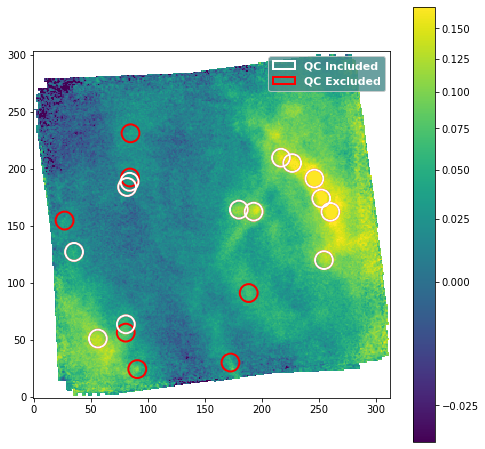

In [27]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

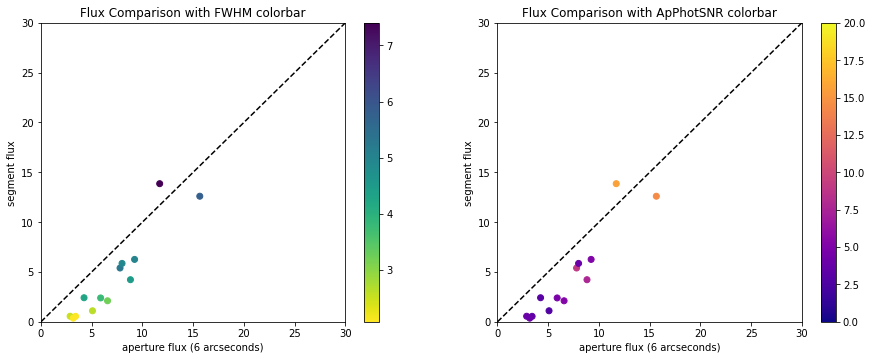

In [28]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

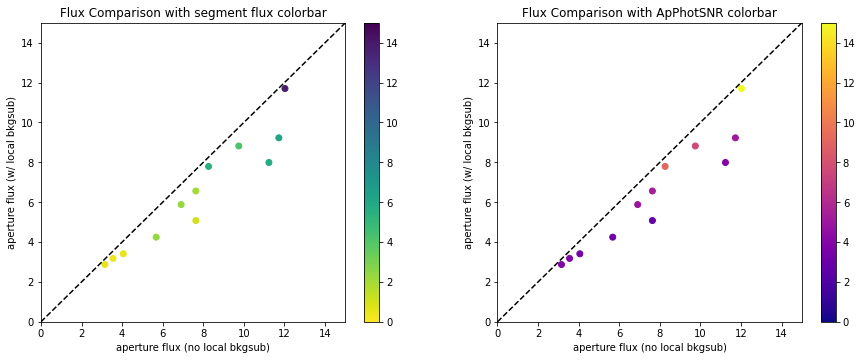

In [29]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [30]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)